# Classificação de Clientes
O objetivo deste processo é classificar novos clientes a partir dos clusters de clientes atuais

Ao logo do tempo novos clientes farão parte do processo de classificação, trazendo uma retroalimentação para o processo de classificação

In [37]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [38]:
# carrega o dataset
dataset = pd.read_csv('01.1-clusterizacao-kmeans.csv', delimiter=';', decimal=',')

faturamentoBruto = dataset['faturamentoBruto']
margemBruta = dataset['margemBruta']
restricoes = dataset['restricoes']
cluster = dataset["cluster"]

dataset_norm = pd.concat([faturamentoBruto, margemBruta, restricoes], axis=1)

scaler = MinMaxScaler()
dataset_norm = scaler.fit_transform(dataset_norm)
dataset_norm = pd.DataFrame(dataset_norm, columns = ['faturamentoBruto','margemBruta','restricoes'])
dataset_norm = pd.concat([dataset_norm, cluster], axis=1)

# print(dataset.head())

Temos 7 clusters de clientes, distribuidos conforme vemos visualmente abaixo

<AxesSubplot:xlabel='cluster', ylabel='count'>

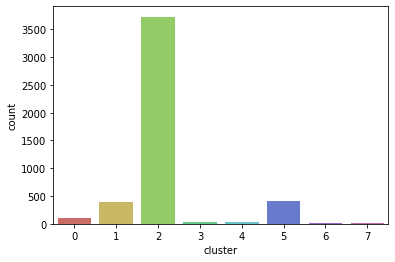

In [39]:
sb.countplot(x='cluster', data=dataset, palette='hls')

## Classificação 
O processo de classificação passa pelo uso dos dados de clientes já conhecidos e clusterizados. Utilizamos o mecanismos de testes a partir dos clientes já conhecidos onde vemos a performance de classificação de 100%. 

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       1.00      1.00      1.00       119
           2       1.00      1.00      1.00      1119
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        11
           5       0.97      0.98      0.97       126
           6       1.00      1.00      1.00         4

    accuracy                           1.00      1420
   macro avg       0.99      0.99      0.99      1420
weighted avg       1.00      1.00      1.00      1420

0.9950704225352113


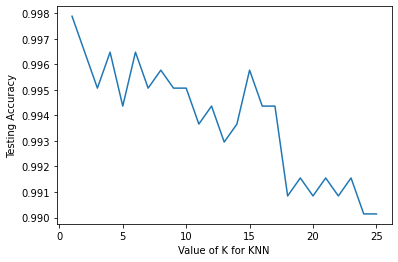

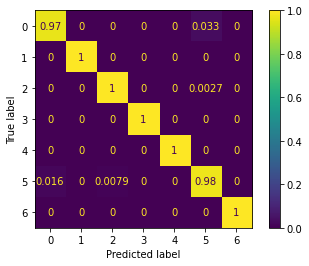

In [40]:
# Separa os clusters para manter a proporcionalidade dos conjuntos entre treino e teste
clusters = range(0,7)

for cluster in clusters:
    dataset = dataset_norm[(dataset_norm['cluster'] == cluster)]  
    X0 = dataset.iloc[:,[0,1,2]].values
    y0 = dataset.iloc[:,3].values
    X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=.3, random_state=25)
    if(cluster>0):
       X_train = np.concatenate([X_train, X0_train], axis=0)
       X_test  = np.concatenate([X_test, X0_test], axis=0)
       y_train = np.concatenate([y_train, y0_train], axis=0)
       y_test  = np.concatenate([y_test, y0_test], axis=0)
    else:
       X_train = X0_train
       X_test  = X0_test
       y_train = y0_train
       y_test  = y0_test

# testa do K=1 até K=26
k_range = range(1, 26)

# Lista todas as acurácias
scores = []

# Faz um loop de 1 a 26 armazena no dicionário scores
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

#print(scores)
#Plota os valores de acc. em função do valor escolhido de K
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

#Avaliando a melhor configuração de KNN
best_KNN = KNeighborsClassifier(n_neighbors=3)
best_KNN.fit(X_train, y_train)
y_pred = best_KNN.predict(X_test)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(best_KNN, X_test, y_test, normalize = 'true')

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

In [41]:
def ajustaDatasete(datasete):
# periodoDemonstrativoEmMeses -> converte valores nulos ou 0 em 1
    datasete['periodoDemonstrativoEmMeses'] = datasete['periodoDemonstrativoEmMeses'].replace(np.nan, 1)
    datasete['periodoDemonstrativoEmMeses'] = datasete['periodoDemonstrativoEmMeses'].replace(0, 1)

# faturamentoBruto -> converte valores nulos em 0 e divide pelo periodoDemonstrativoEmMeses
    datasete['faturamentoBruto'] = datasete['faturamentoBruto'].replace(np.nan, 0)
    datasete['faturamentoBruto'] = datasete['faturamentoBruto'] / datasete['periodoDemonstrativoEmMeses']

# margemBruta -> converte valores nulos em 0 e divide pelo periodoDemonstrativoEmMeses
    datasete['margemBruta'] = datasete['margemBruta'].replace(np.nan, 0)
    datasete['margemBruta'] = datasete['margemBruta'] / datasete['periodoDemonstrativoEmMeses']

# monta o datasete que será trabalhado
    datasete = pd.concat([
        datasete["faturamentoBruto"],
        datasete["margemBruta"],
        datasete["restricoes"]
    ], axis=1)

# faturamentoBruto -> remove valores nulos ou inferiores a 1.000,00 (outliers?)
    datasete.dropna(subset=['faturamentoBruto'], inplace=True)
    faturamentoBrutoIdx = datasete[(datasete['faturamentoBruto'] < 1000.0)].index
    datasete.drop(faturamentoBrutoIdx, inplace=True)
# faturamentoBruto -> remove valores nulos ou superiores a 100.000.000,00 (fora do modelo)
    faturamentoBrutoIdx = datasete[(datasete['faturamentoBruto'] > 100000000.0)].index
    datasete.drop(faturamentoBrutoIdx, inplace=True)

# restricoes -> converte valores nulos em falso e transforma bool em int
    datasete['restricoes'] = datasete['restricoes'].replace(np.nan, False)
    datasete['restricoes'] = datasete['restricoes'].astype(int)

# indexa novamente o datasete para remover índices ainda em memória
    datasete.reset_index(drop=True, inplace=True)
    
    return(datasete)


## Teste do Classificador utilizando dados Reais
Buscamos um arquivo da CVM, com dados de resultado de empresas abertas do ano de 2016.

A partir destes dados, efetuamos a preparação para aplicação do modelo, normalizando o faturamento e margem para período mensal. 

Como um modelo de classificação trabalha com situações previamente conhecidas, eliminamos empresas com faturamento acima dos conhecidos através da divisão por uma constante aleatória.

In [42]:
# Dados Obtidos da CVM - http://dados.cvm.gov.br/dataset/cia_aberta-doc-dfp/resource/fdf29235-55ab-40e7-8de8-3a9bc58621ed
# carrega o dataset de novos clientes
novosclientes = pd.read_csv('novos-clientes-meu.csv', delimiter=';', decimal=',')

novosclientes['faturamentoBruto'] = (novosclientes['faturamentoBruto'] / 581.53246789) 
#novosclientes = pd.read_csv('novos-clientes.csv', encoding = "ISO-8859-1")

newDataset = ajustaDatasete(novosclientes)

# Normaliza pelo escalar
# Reutiliza o mesmo escalar do treinamento
datasete_norm = scaler.transform(newDataset)
datasete_norm = pd.DataFrame(datasete_norm, columns = ['faturamentoBruto','margemBruta','restricoes'])
    

In [43]:
clientesClassificados = best_KNN.predict(datasete_norm)
clientesClassificados

array([3, 0, 3, 0, 2, 2, 2, 3, 3, 3, 3, 0, 3, 5, 5, 2, 2, 5, 2, 5, 2, 3,
       3, 3, 5, 3, 3, 5, 0, 3, 5, 3, 3, 5, 0, 5, 1, 0, 3, 3, 2, 4, 3, 2,
       0, 3, 2, 0, 2, 4, 0, 0, 4, 5, 5, 2, 3, 0, 5, 2, 2, 4, 2, 2, 1, 3,
       3, 3, 0, 2, 3, 5, 0, 3, 0, 5, 2, 2, 5, 3, 2, 5, 5, 1, 3, 5, 4, 5,
       3, 5, 1, 2, 0, 1, 2, 2, 2, 0, 5, 5, 0, 0, 3, 5, 2, 5, 2, 5, 1, 3,
       5, 2, 5, 5, 2, 2, 5, 5, 0, 3, 3, 1, 2, 5, 5, 5, 2, 2, 5, 5, 0, 5,
       5, 1, 3, 5, 2, 3, 5, 0, 3, 3, 0, 2, 5, 0, 0, 3, 2, 5, 1, 2, 5, 5,
       5, 0, 0, 2, 2, 0, 0, 2, 3, 3, 2, 5, 3, 3, 5, 5, 3, 3, 2, 0, 2, 5,
       3, 3, 2, 5, 2, 0, 3, 3, 5, 3, 2, 5, 3, 5, 2, 0, 5, 2, 0, 3, 3, 3,
       5, 5, 5, 3, 5, 2, 5, 3, 5, 4, 5, 2, 5, 5, 2, 5, 3, 3, 3, 4, 0, 5,
       3, 3, 2, 3, 0, 0, 5, 3, 3, 2, 5, 5, 5, 5, 0, 1, 2, 1, 4, 2, 4, 2,
       2, 0, 3, 3, 3, 0, 0, 5, 5, 3, 0, 5, 0, 0, 3, 5, 3, 3, 2, 5, 0, 2,
       5, 5, 2, 5, 3, 3, 3, 5, 2, 1, 2, 1, 5, 1, 5, 5, 0, 3, 0, 0, 2, 3,
       2, 0, 2, 3, 2, 5, 5, 2, 2, 0, 3, 5, 3, 5, 0,

In [44]:
newDataset['cluster'] = pd.DataFrame(clientesClassificados)
newDataset

,faturamentoBruto,margemBruta,restricoes,cluster
0,2.407432e+07,1.125000e+10,0,3
1,4.198044e+05,1.330303e+08,0,0
2,8.705283e+06,1.350911e+09,0,3
3,3.030146e+05,1.530358e+08,0,0
4,8.032512e+03,1.330633e+07,0,2
...,...,...,...,...
300,9.245081e+05,2.145902e+08,0,0
301,1.189777e+05,5.308933e+07,0,5
302,1.113144e+05,4.716900e+07,0,5
303,7.664949e+03,3.702917e+06,0,2


In [45]:
newDataset.groupby(by=['cluster','restricoes']).count()

faturamentoBruto  margemBruta
cluster restricoes                               
0       0                         49           49
1       1                         14           14
2       0                         68           68
3       0                         76           76
        1                          1            1
4       1                         10           10
5       0                         87           87

In [46]:
# salva os dados clusterizados em csv
newDataset.to_csv(path_or_buf='02.1-classificacao-knn.csv', sep=';', decimal=',')